# Introduction

The project aims to create a **Machine Learning** powered model which is capable of classifying the emotions of the text (in the form of short quotes/comments) with predefined labels of emotions.

Emotion detection, also known as sentiment analysis, is now one of the most attractive subfields of Machine Learning, especially Natural Language Processing (NLP) due to its wide applications in many aspects of modern life, such as providing emotional information to help people developing insights or making decisions. In this project, we specifically try to convey the main emotion of a comment sentence. Generally, we expect the model to be able to take the input sentence in the form of short comments and returns its major emotion(s), corresponding to one of the predefined labels.

Our approach to solving this problem is to split it into two halves:

  1.   Data Preprocessing
  2.   Model training and Result

For detail of each half, please go into the section


The dataset we use in this project is obtained from Kaggle: [EDFT Dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)

Connect to Google Drive

# **Data Preprocessing**

## Importation & Data loading

Preparing necessary packages (may need to add more):

In [1]:
import numpy as np  # Work with multi-dimenional data
import pandas as pd # Work with relational data
import matplotlib.pyplot as plt # Visualize data
import seaborn as sns # Visualize data base on matplotlib
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")
# Because I hate seeing stupid warnings~

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
# Used for automatic feature extraction
from sklearn.pipeline import Pipeline
# Used for automating processes
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
# Used for spliting test and tuning hyperparameter
from sklearn.model_selection import StratifiedShuffleSplit
# Used for k-fold validiator in multi-classficiation

from sklearn.neighbors import KNeighborsClassifier
# Defining kNN
from sklearn.tree import DecisionTreeClassifier
# Defining Decision Tree
from sklearn.ensemble import RandomForestClassifier
# Defining Random Forest
from sklearn.svm import SVC
# Defining Classifier SVM
from sklearn.naive_bayes import MultinomialNB, GaussianNB
# Defining Naive Bayes
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Used for calculating metric-related scores of the model performance, and plotting the confusion matrix

%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load data from files

In [2]:
directory = 'data/dataset/'

# This method use to extract all the file in the input list
def extract_data(files):
  data_x_raw = list()
  data_y_raw = list()
  for file in files:
    with open(directory + file) as f:
      for line in f:
        line = line.strip('\n')
        x_raw, y_raw = line.split(sep=';')

        data_x_raw.append(x_raw)
        data_y_raw.append(y_raw)

  return data_x_raw, data_y_raw

In [3]:
# Get all data

X_raw, y_raw = extract_data(['train.txt', 'val.txt', 'test.txt'])
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size = 0.2)

print("Traning data's size is:", len(X_train_raw))
print("Test data's size is:", len(X_test_raw))

Traning data's size is: 16000
Test data's size is: 4000


## Initial Feature Extraction


Removing the stopword

In [30]:
file = open("tmp.txt", 'r', encoding='utf-8')
stopword_list = file.read().split('\n')
file.close()

Vectorize the data:

1.   Bag Of Words model (https://en.wikipedia.org/wiki/Bag-of-words_model)
2.   BoW/TF-IDF model (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)



In [5]:
# Scikit CountVectorizer:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

count_vector = CountVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow = count_vector.transform(X_train_raw)
X_test_bow = count_vector.transform(X_test_raw)
dictionary = count_vector.get_feature_names_out()

print("Shape of preprocessed training data X using BoW model is: ", X_train_bow.shape)

Shape of preprocessed training data X using BoW model is:  (16000, 85604)


In [6]:
# Scikit TF-IDF:
# Documentation: (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

tfidf_vector = TfidfVectorizer(stop_words=stopword_list, ngram_range=(1, 2))
tfidf_vector.fit(X_train_raw, X_test_raw)
X_train_tfidf = tfidf_vector.transform(X_train_raw)
X_test_tfidf = tfidf_vector.transform(X_test_raw)

print("Shape of preprocessed training data X using BoW/TF-IDF model is: ", X_train_tfidf.shape)

Shape of preprocessed training data X using BoW/TF-IDF model is:  (16000, 85604)


Cast output list to ndarray

In [7]:
y_train = np.asarray(y_train_raw)
y_test = np.asarray(y_test_raw)

*Luckily we're quite done with the abbreviations!*

Another way: Using Word2Vec to capture the semantics
(Um, we'd talk about that later, ok?)


## Initial exploratory Data Analysis (EDA)

Average length of the comment:

In [8]:
# Calculate average number of characters
sum_of_chars = sum([len(x) for x in X_train_raw])
mean_number_chars = sum_of_chars / len(X_train_raw)

# Calculate average number of words
sum_of_words = sum([len(x.split()) for x in X_train_raw])
mean_number_words = sum_of_words / len(X_train_raw)

# Print
print('The mean number of characters of each line is: %d' % mean_number_chars)
print('The mean number of words of each line is: %d' % mean_number_words)

The mean number of characters of each line is: 96
The mean number of words of each line is: 19


Statistic of output labels:

Number of labels is: 6
Labels: anger, fear, joy, love, sadness, surprise

----------------------------------------------------------------------------



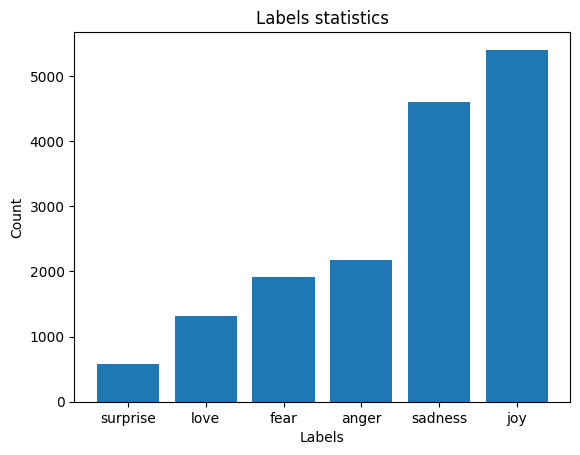

In [9]:
# Number of labels:
labels = np.unique(y_train)
print('Number of labels is: %d' % len(labels))
print('Labels: ' + ', '.join(labels))
print('\n----------------------------------------------------------------------------\n')

# Plot:
df = pd.DataFrame(
  dict(
    labels = labels,
    label_elements_count = [y_train_raw.count(label) for label in labels]
  )
)
df = df.sort_values('label_elements_count')

plt.title(label='Labels statistics')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.bar('labels', 'label_elements_count', data=df)

plt.show()

Statistics of words with the highest frequency of each label:

In [ ]:
def show_highest_frequency_words():
  vect_arr = X_train_bow.toarray()
  vect_aggr = np.zeros(shape=(len(labels), vect_arr.shape[1]))

  for idx in range(len(vect_arr)):
    label_idx = int(np.where(labels==y_train[idx])[0][0])

    vect_aggr[label_idx] += vect_arr[idx]

  fig, axs = plt.subplots(3, 2)

  for label_idx in range(len(labels)):
    axs_x, axs_y = label_idx // 2, label_idx % 2

    plt_ref = axs[axs_x][axs_y]
    plt_ref.set_title(labels[label_idx].upper())

    x_axis, y_axis = list(), list()
    n_argmax = np.argpartition(vect_aggr[label_idx], -7)[-7:]
    n_argmax = n_argmax[np.argsort(vect_aggr[label_idx][n_argmax])]
    for i in n_argmax:
      x_axis.append(dictionary[i])
      y_axis.append(vect_aggr[label_idx][i])

    x_axis = np.asarray(x_axis)
    y_axis = np.asarray(y_axis)

    plt_ref.barh(x_axis, y_axis)

  # Adjust layout
  plt.tight_layout()

  # Show the plot
  plt.show()

show_highest_frequency_words()

## Data Fixing

This part will eliminate all the words that have bad influence to our data.
All the words will be stored in a file stored in file *filtered_words.txt*

* Words appears so many times but don't contribute much (*feel*, *feeling*,...).
* Words have no mean (*aa*,*ab*,...)
* Words appears only a few

In [193]:
file = open("data/stopwords/filtered_words.txt", 'r', encoding='utf-8')
filtered_words = file.read().split('\n')

file = open("data/stopwords/stop_words_english.txt", 'r', encoding='utf-8')
stop_words = file.read().split('\n')

new_stopwords = stopword_list + stop_words + filtered_words
unfiltered_stopwords = stop_words + stopword_list

print(len(new_stopwords), len(unfiltered_stopwords))

1245 995


Create tokenize function with the help of nltk packages

In [194]:
stemmer = PorterStemmer()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in new_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def unfiltered_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in unfiltered_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

Fit the data again

In [170]:
# Dictionary semi_filtered: Using basic stopwords only

count_vector = CountVectorizer(stop_words=unfiltered_stopwords, tokenizer=unfiltered_tokenize, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow_semi_filtered = count_vector.transform(X_train_raw)
X_test_bow_semi_filtered = count_vector.transform(X_test_raw)
dictionary_semi_filtered = count_vector.get_feature_names_out()

In [171]:
# Dictionary semi_mono: Using basic filters, containing only 1-gram, used to perform LASSO-filter to obtain L1 dict

count_vector = CountVectorizer(stop_words=unfiltered_stopwords, tokenizer=unfiltered_tokenize, ngram_range=(1, 1))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow_semi_mono = count_vector.transform(X_train_raw)
X_test_bow_semi_mono = count_vector.transform(X_test_raw)
dictionary_semi_mono = count_vector.get_feature_names_out()

Sorting out the useless stopwords to make L1 dictionary. We perform LASSO Logistic Regression on dictionary_semi_mono to sort out all useless stopwords (criterion: L2 norm of the L1 weight = 0), then make it a new stopword list.

In [173]:
linear_semi_mono = LogisticRegression(penalty='l1', solver='saga')
linear_semi_mono.fit(X_train_bow_semi_mono, y_train)

LogisticRegression(penalty='l1', solver='saga')

In [175]:
print(X_train_bow_semi_mono.shape)

(16000, 9994)


Score of on train are:
	- Accuracy score: 0.913
	- Micro F1 score: 0.913
	- Macro F1 score: 0.890
Score of on test are:
	- Accuracy score: 0.869
	- Micro F1 score: 0.869
	- Macro F1 score: 0.835


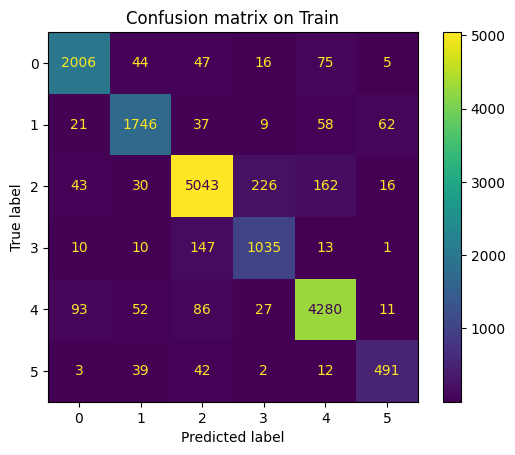

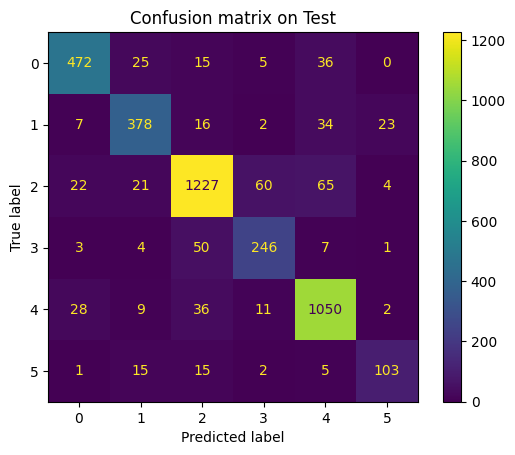

In [191]:
# PLEASE COMPILE THE PRESET FUNCTION PART BELOW FIRST!
evaluate_model(linear_semi_mono, X_train_bow_semi_mono, X_test_bow_semi_mono, y_train, y_test, include_training = True)

In [181]:
print(linear_semi_mono.coef_.shape)
lin_coef = linear_semi_mono.coef_.T

(6, 9994)


In [182]:
def norm2(a: tuple):
    res = 0
    for i in a:
        res += i**2
    return res

In [186]:
useless_coef = list()
for i in range(lin_coef.shape[0]):
    if norm2(lin_coef[i]) == 0:
        useless_coef.append(i)

In [187]:
print(len(useless_coef))

8615


In [189]:
with open("data/stopwords/useless.txt", 'w') as file:
    for i in useless_coef:
        file.write(dictionary_semi_mono[i])
        file.write('\n')

In [190]:
file = open("data/stopwords/useless.txt", 'r', encoding='utf-8')
useless = file.read().split('\n')

L1_stopwords = unfiltered_stopwords + useless

In [195]:
def useless_tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in L1_stopwords]
    stems = [stemmer.stem(token) for token in tokens]
    return stems

In [196]:
# Dictionary L1: Obtained by selecting useful tokens from semi_mono using L1 decomposition.

count_vector = CountVectorizer(stop_words=L1_stopwords, tokenizer=useless_tokenize, ngram_range=(1, 2))
count_vector.fit(X_train_raw, X_test_raw)
X_train_bow_L1 = count_vector.transform(X_train_raw)
X_test_bow_L1 = count_vector.transform(X_test_raw)
dictionary_L1 = count_vector.get_feature_names_out()

In [197]:
print(len(dictionary_semi_filtered), len(dictionary_L1), len(dictionary_semi_mono))

73152 37309 9994


Fixing results:

In [ ]:
show_highest_frequency_words()

## Variables summary




---


**X_train_raw**, **y_train_raw**: ***list***

Raw training data which is extracted directly from files.

---


**X_test**, **y_test**: ***list***

  Raw testing data which is extracted directly from files.

---


**stopword_list**: ***list***

 List of stop words used in BoW and BoW/TF-IDF models

---


**dictionary**: ***numpy.ndarray***

 Dictionary of words which is used to vectorized the data and number of occurences.

---


**X_train_bow**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW model.

---


**X_train_tfidf**: ***scipy.sparse._csr.csr_matrix***

 Training data input which is vectorized by the BoW/TFIDF model

---


**X_test_bow**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW model.

---


**X_test_tfidf**: ***scipy.sparse._csr.csr_matrix***

 Testing data input which is vectorized by the BoW/TFIDF model

---


**y_train**: ***numpy.ndarray***

 Preprocessed traning data output


---

# **Model training and result**

## Preset functions

### Summary

**evaluate_model(*model, X_train, X_test, y_train, y_test, include_training = False*)**: Evaluate score and draw confusion matrix of a model.
- ***model***: Your trained model.
- ***X_train, X_test, y_train, y_test***: The datasets used to evluate the model.
- ***include_training***: Trigger True if you want to output the training metrics. On default, false.

---

**draw_learning_curve(*model, X_train, y_train, cv = 5, train_sizes = np.linspace(0.2, 1, 5), scoring = 'accuracy'*)**: Draw the learning curve for a model.
- ***model***: Your trained model.
- ***X_train, y_train***: The datasets on which you want to draw the learning curve.
- ***cv***: Number of cross-validation folds you want to commit. On default, 5.
- ***train_sizes***: The threshold list for the learning curve to be evaluated. On default, [.2, .4, .6, .8, 1]
- ***scoring***: Scoring metric used. On default, accuracy score is used.

---

### Implementation


**evaluate_model:**

In [178]:
def evaluate_model(model, X_train, X_test, y_train, y_test, include_training = False):

  # [EVALUATE ON THE TRAIN]
  if include_training == True:
    # Predict from the train
    y_pred = model.predict(X_train)

    # Calculate score
    print("Score of on train are:")
    print("\t- Accuracy score: {:.3f}".format(accuracy_score(y_pred, y_train)))
    print("\t- Micro F1 score: {:.3f}".format(f1_score(y_pred, y_train, average = 'micro')))
    print("\t- Macro F1 score: {:.3f}".format(f1_score(y_pred, y_train, average = 'macro')))
    
    # Draw confusion matrix
    cm = confusion_matrix(y_pred, y_train)
    cm_plt = ConfusionMatrixDisplay(cm)
    cm_plt.plot()
    cm_plt.ax_.set_title("Confusion matrix on Train")

  # [EVALUATE ON THE TEST]
  # Predict from the test
  y_pred = model.predict(X_test)

  # Calculate score
  print("Score of on test are:")
  print("\t- Accuracy score: {:.3f}".format(accuracy_score(y_pred, y_test)))
  print("\t- Micro F1 score: {:.3f}".format(f1_score(y_pred, y_test, average = 'micro')))
  print("\t- Macro F1 score: {:.3f}".format(f1_score(y_pred, y_test, average = 'macro')))

  # Draw confusion matrix
  cm = confusion_matrix(y_pred, y_test)
  cm_plt = ConfusionMatrixDisplay(cm)
  cm_plt.plot()
  cm_plt.ax_.set_title("Confusion matrix on Test")

---

**draw_learning_curve:**

In [12]:
def draw_learning_curve(model, X_train, y_train, cv = 5, train_sizes = np.linspace(0.2, 1, 5), scoring = 'accuracy'):
  
  # Calculate list score of cross validation
  _, train_score, test_score = learning_curve(model, X_train, y_train, n_jobs = -1, cv = cv,
                                              train_sizes = train_sizes, scoring = scoring)

  # Calculate mean and standard deviation of the scores
  train_mean_score = np.mean(train_score, axis = 1)
  train_std_score = np.std(train_score, axis = 1)
  test_mean_score = np.mean(test_score, axis = 1)
  test_std_score = np.std(test_score, axis = 1)

  # Draw the plot
  plt.fill_between(train_sizes, train_mean_score - train_std_score, train_mean_score + train_std_score, alpha = 0.1, color = 'g')
  plt.fill_between(train_sizes, test_mean_score - test_std_score, test_mean_score + test_std_score, alpha = 0.1, color = 'r')

  plt.plot(train_sizes, train_mean_score, color = 'g')
  plt.plot(train_sizes, test_mean_score, color = 'r')

## Data comparation

**DEVELOPER'S NOTE: This section is only for comparing preprocessing methods. The criteria used will be L2 Logistic Regression**

In [205]:
logistic_semi_filtered = LogisticRegression(penalty='l2', solver='saga')
logistic_semi_filtered.fit(X_train_bow_semi_filtered, y_train)

LogisticRegression(solver='saga')

In [206]:
logistic_L1 = LogisticRegression(penalty='l2', solver='saga')
logistic_L1.fit(X_train_bow_L1, y_train)

LogisticRegression(solver='saga')

Score of on train are:
	- Accuracy score: 0.990
	- Micro F1 score: 0.990
	- Macro F1 score: 0.988
Score of on test are:
	- Accuracy score: 0.879
	- Micro F1 score: 0.879
	- Macro F1 score: 0.840


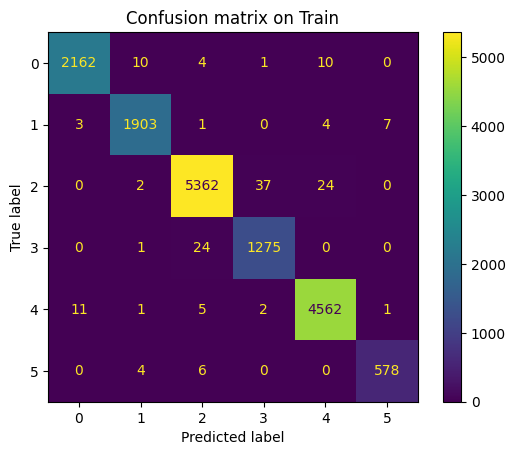

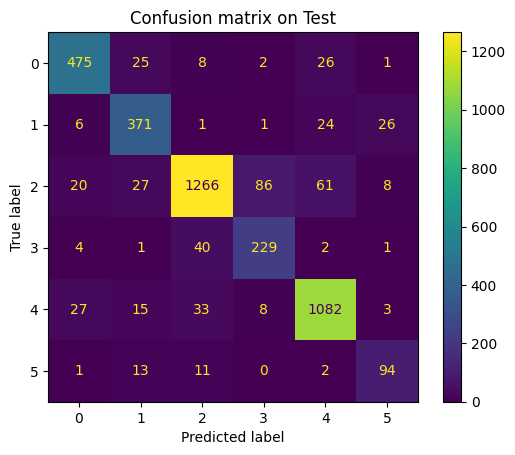

In [203]:
evaluate_model(logistic_semi_filtered, X_train_bow_semi_filtered, X_test_bow_semi_filtered, 
               y_train, y_test, include_training = True)

Score of on train are:
	- Accuracy score: 0.975
	- Micro F1 score: 0.975
	- Macro F1 score: 0.966
Score of on test are:
	- Accuracy score: 0.871
	- Micro F1 score: 0.871
	- Macro F1 score: 0.827


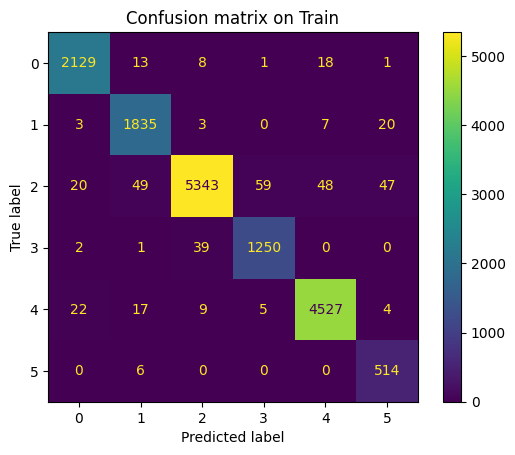

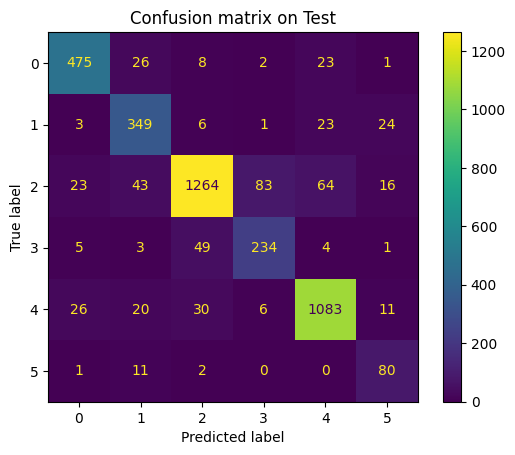

In [204]:
evaluate_model(logistic_L1, X_train_bow_L1, X_test_bow_L1, y_train, y_test, include_training = True)

**Conclusion: The L1-trimmed data provides comparable accuracy (compared to the original dictionary) with smaller time spent on system**

In [207]:
svm_model_semi_filtered = SVC()
svm_model_semi_filtered.fit(X_train_bow_semi_filtered, y_train)

SVC()

In [209]:
svm_model_L1 = SVC()
svm_model_L1.fit(X_train_bow_L1, y_train)

SVC()

Score of on train are:
	- Accuracy score: 0.975
	- Micro F1 score: 0.975
	- Macro F1 score: 0.967
Score of on test are:
	- Accuracy score: 0.859
	- Micro F1 score: 0.859
	- Macro F1 score: 0.812


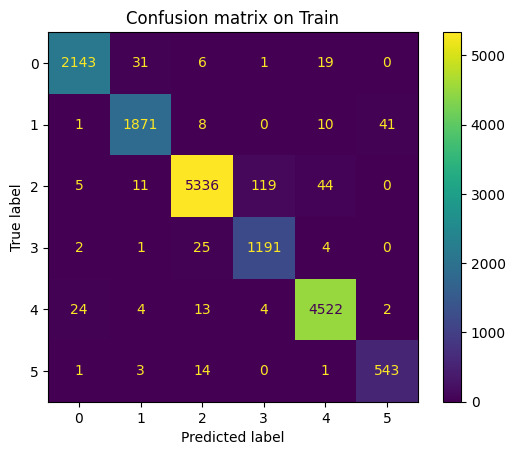

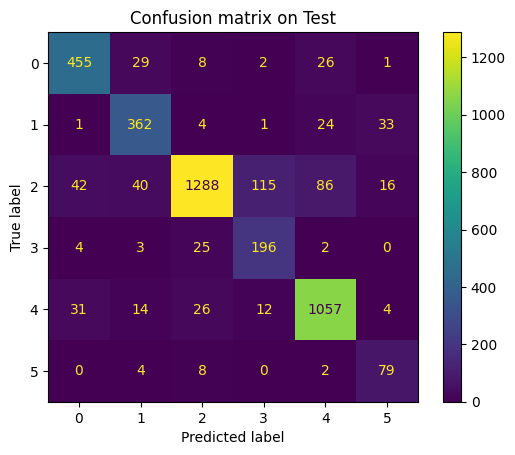

In [210]:
evaluate_model(svm_model_semi_filtered, X_train_bow_semi_filtered, X_test_bow_semi_filtered, 
               y_train, y_test, include_training = True)

Score of on train are:
	- Accuracy score: 0.959
	- Micro F1 score: 0.959
	- Macro F1 score: 0.939
Score of on test are:
	- Accuracy score: 0.854
	- Micro F1 score: 0.854
	- Macro F1 score: 0.798


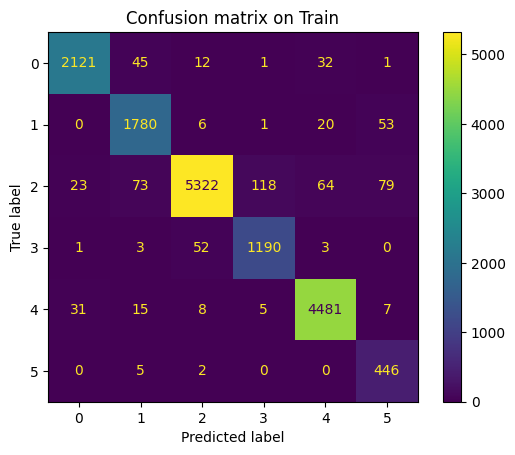

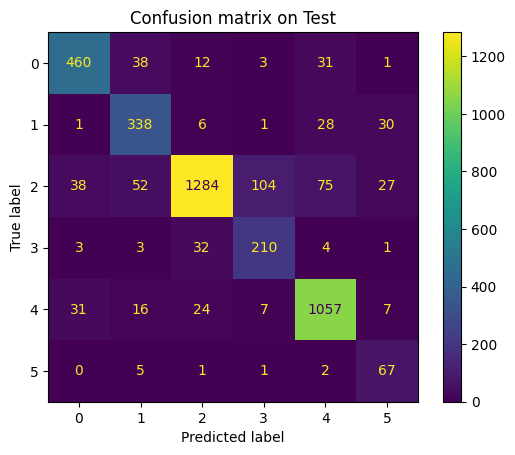

In [211]:
evaluate_model(svm_model_L1, X_train_bow_L1, X_test_bow_L1, 
               y_train, y_test, include_training = True)

**CONCLUSION: L1-trimmed dictionary provided a much faster approach, especially in time-consuming models like Support Vector Machine, while producing results with reasonable margins of error**

In [ ]:
text = "I feels shitty today"
print('fun day' in dictionary)
vect = count_vector.transform([text])
print(vect)
print(count_vector.inverse_transform(vect))

best_knn_model.predict(vect)

# **Conclusion**